In [1]:
import pandas as pd
import numpy as np
import json
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sentence_transformers import SentenceTransformer
import xgboost as xgb
import matplotlib.pyplot as plt
import shap

/Users/henrychiu/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load grabbed data into dataframes (after get the jobs info)

In [2]:

def load_data(path: str) -> pd.DataFrame:
    from_json = json.load(open(path))
    #print(len(from_json[0]["result"]))
    df = pd.json_normalize(data=from_json[0]["result"])
    df = df.drop(
        columns=[
            "HittedKeywords",
            "CompanyDetail",
            "CompanyDetail.LastUpdate",
            "CompanyDetail.Linkedin",
            "CompanyDetail.Locations",
            "CompanyDetail.ReferenceId",
            "CompanyDetail.id",
            "CompanyDetail.Url",
            # "PostId",
            "PostUrl",
            "ExpiringDate",
            "id",
        ]
    )
    return df


In [3]:

def load_other_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [6]:

# Function to convert salary strings with K, M, etc.
def number_conversion(s, POWERS):
    if s[-1] in POWERS.keys():
        return float(s[:-1]) * POWERS[s[-1]]
    else:
        return float(s)


# Function to determine the time period in salary
def get_time_period(salary):
    if re.search(r'\bper hour\b|\b/hr\b', salary.lower()):
        return 'hourly'
    elif re.search(r'\bper month\b|\b/month\b', salary.lower()):
        return 'monthly'
    elif re.search(r'\bper week\b|\b/week\b', salary.lower()):
        return 'weekly'
    else:
        return 'yearly'

# Main feature conversion function with WorkType weighting
def feature_conversion(df: pd.DataFrame, POWERS: dict) -> pd.DataFrame:
    
    # Salary conversion function
    def convert_salary(salary, POWERS):
        time_period = get_time_period(salary)
        
        # Extract numerical values and modifiers (K, M, etc.)
        wage = re.findall(r"[\d|,|.]+[k|K|m|M|g|G]?", salary)
        wage = [i.replace(',', '') for i in wage]        
        wage = [number_conversion(i, POWERS) for i in wage if i.strip() != ""]
    
        # Adjust salary based on time period
        if time_period == 'hourly':
            wage = [i * 38 * 52 for i in wage if i is not None]  # Example: 38 hours/week, 52 weeks/year
        elif time_period == 'monthly':
            wage = [i * 12 for i in wage if i is not None]      # 12 months/year
        elif time_period == 'weekly':
            wage = [i * 52 for i in wage if i is not None]      # 52 weeks/year
        # No adjustment needed for 'yearly'
    
        return wage if wage else [np.nan, np.nan]  # Return list of None if no wage found
    
    # Function to extract PayRangeMin and PayRangeMax
    def extract_pay_range(pay_range):
        if len(pay_range) == 2:
            return pd.Series([pay_range[0], pay_range[1]])
        elif len(pay_range) == 1:
            return pd.Series([pay_range[0], pay_range[0]])
        else: 
            return pd.Series([np.nan, np.nan])  # Handle cases where no salary information is found
        
    # Define WorkType weights
    worktype_weights = {
        'Full Time': 1.0,
        'Contract/temp': 0.7,
        'Part Time': 0.5,
        'Casual/vacation': 0.3
    }
    
    # Standardize WorkType entries to match the keys in worktype_weights
    df['WorkType'] = df['WorkType'].str.strip().str.title()
    
    # Apply salary conversion and extract min/max ranges
    df_new_save = pd.DataFrame()
    df_new_save[['PostId']] = df[['PostId']]
    
    # Convert salary and extract pay range
    df_new_save[['PayRangeMin', 'PayRangeMax']] = df.apply(
        lambda row: extract_pay_range(convert_salary(row['PayRange'], POWERS)), axis=1
    )
    
    # Convert 'WorkType' to categorical
    df["WorkType"] = df["WorkType"].astype("category")
    
    # Map WorkType to weights
    df_new_save['WorkType'] = df['WorkType'].map(worktype_weights)
    
    # Handle WorkTypes not in the mapping by assigning a default weight of 1.0
    df_new_save['WorkType'] = df_new_save['WorkType'].fillna(1.0)
    
    # Apply the weight to PayRangeMin and PayRangeMax
    df_new_save['PayRangeMin'] = df_new_save['PayRangeMin'] * df_new_save['WorkType']
    df_new_save['PayRangeMax'] = df_new_save['PayRangeMax'] * df_new_save['WorkType']
    
    # Drop the 'WorkType' column if it's no longer needed
    df_new_save = df_new_save.drop(columns=['WorkType'])
    
    # Convert other columns to categorical as needed
    df["CompanyDetail.GroupSize"] = df["CompanyDetail.GroupSize"].astype("category")      
    df["CompanyDetail.Industry"] = df["CompanyDetail.Industry"].astype("category")
    
    # Optional: Handle missing PayRangeMin and PayRangeMax by filling with 0 or another strategy
    #df_new_save[['PayRangeMin', 'PayRangeMax']] = df_new_save[['PayRangeMin', 'PayRangeMax']].fillna(0)
    
    # Ensure PayRangeMin is less than or equal to PayRangeMax
    df_new_save['PayRangeMin'] = df_new_save[['PayRangeMin', 'PayRangeMax']].min(axis=1)
    df_new_save['PayRangeMax'] = df_new_save[['PayRangeMin', 'PayRangeMax']].max(axis=1)
    
    return df_new_save


In [7]:
# Function to parse location into suburb, city, and state
def parse_location(location, STATE_MAPPING):
    parts = location.split(',')

    if len(parts) == 1:
        # Handle case like "Sydney NSW"
        city_state = parts[0].strip().rsplit(' ', 1)
        if len(city_state) == 2 and city_state[1] in STATE_MAPPING:
            return pd.Series(['', city_state[0], '', STATE_MAPPING[city_state[1]]])
    
    if len(parts) == 2:
        # Handle cases like "Galiwin'ku, Katherine & Northern Australia NT"
        suburb = parts[0].strip()
        city_region = parts[1].strip().rsplit(' ', 1)[0]  # Strip off the state portion
        state_abbr = parts[1].strip().rsplit(' ', 1)[1]   # Get state abbreviation

        if '&' in city_region:
            city, region = city_region.split('&', 1)
            city = city.strip()  # Take everything before '&' as city
            region = region.strip()  # Take everything after '&' as region
        else:
            city = city_region
            region = ''

        if state_abbr in STATE_MAPPING:
            return pd.Series([suburb, city, region, STATE_MAPPING[state_abbr]])
    
    if len(parts) == 3:
        # Handle case like "Broadmeadow, Newcastle, Maitland & Hunter NSW"
        suburb = parts[0].strip()
        city = parts[1].strip()
        region_state = parts[2].strip().rsplit(' ', 1)

        if '&' in region_state[0]:
            region = region_state[0].split('&', 1)[0].strip()  # Only take the first word before '&'
        else:
            region = region_state[0].strip()

        state_abbr = region_state[1].strip()
        if state_abbr in STATE_MAPPING:
            return pd.Series([suburb, city, region, STATE_MAPPING[state_abbr]])

    # Return empty values if no match
    return pd.Series(['', '', '', ''])



In [8]:
# Function to get latitude and longitude of a location
def get_lat_lon(location_name, data):
    for location in data:
        if location['place_name'].lower() == location_name.lower():
            return location['latitude'], location['longitude']
    return None, None

# Example function to calculate the distance between two locations
def haversine_distance(lat1, lon1, lat2, lon2):
    from math import radians, cos, sin, sqrt, atan2

    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Differences between the coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance



In [9]:
# Function to geocode location
def geocode_location(location, data):
    parts = location.split(',')
    fallback_location = parts[0]
    lat, long = get_lat_lon(fallback_location, data)
    
    if not lat or not long:
        # If geocoding fails, try with city
        if len(parts) > 1:
            fallback_location = parts[1].strip()
            lat, long = get_lat_lon(fallback_location, data)
            
        # If still not found, try with region
        if (not lat or not long) and len(parts) > 2:
            fallback_location = parts[2].strip()
            lat, long = get_lat_lon(fallback_location, data)
        
        # If still not found, try with state 
        if (not lat or not long) and len(parts) > 3:
            fallback_location = parts[-1].strip()
            lat, long = get_lat_lon(fallback_location, data)   
    
    return (lat, long) if lat and long else (None, None)



In [11]:
def calculate_distances(df, user_location, postcode_data):
    # Geocode the user's location
    user_lat, user_long = geocode_location(user_location, postcode_data)

    # Initialize an array to hold distances
    distances = []
    
    # Calculate distance for each company location
    for index, row in df.iterrows():
        penalty = 0
        company_lat, company_long = None, None
                # Check if any location fields are available
        if row['suburb']:
            company_lat, company_long = geocode_location(row['suburb'], postcode_data)
            if company_lat == None and company_long == None:
                company_lat, company_long = geocode_location(row['city'], postcode_data)
                penalty +=10
                if company_lat == None and company_long == None:
                    company_lat, company_long = geocode_location(row['region'], postcode_data)
                    penalty +=15
                    if company_lat == None and company_long == None:
                        company_lat, company_long = geocode_location(row['state'], postcode_data)
                        penalty +=30
                
        elif row['city']:
            penalty +=10
            company_lat, company_long = geocode_location(row['city'], postcode_data)
            if company_lat == None and company_long == None:
                    company_lat, company_long = geocode_location(row['region'], postcode_data)
                    penalty +=15
                    if company_lat == None and company_long == None:
                        company_lat, company_long = geocode_location(row['state'], postcode_data)
                        penalty +=30
        elif row['region']:
            penalty +=25
            company_lat, company_long = geocode_location(row['region'], postcode_data)
            if company_lat == None and company_long == None:
                        company_lat, company_long = geocode_location(row['state'], postcode_data)
                        penalty +=30
            
        elif row['state']:
            penalty +=55
            company_lat, company_long = geocode_location(row['state'], postcode_data)
        

        if user_lat and user_long and company_lat and company_long:
            distance = haversine_distance(user_lat, user_long, company_lat, company_long)
          
            distance +=penalty
            
            distances.append(distance)
        else:
            distances.append(None)  # Handle cases where geocoding fails

    return distances

In [12]:
def preprocess_zeros_nan(new_jobs_df, user_location):
    new_jobs_df = new_jobs_df.copy()
    
    # Handle missing values (example: filling NaNs in 'distance_km' with the mean)
    new_jobs_df['distance_km'].fillna(new_jobs_df['distance_km'].mean(), inplace=True)
    
    # Apply condition
    mask = new_jobs_df['Locations'] != user_location
    
    # Fill zeros with the mean
    mean_distance_km = new_jobs_df['distance_km'].mean()
    new_jobs_df.loc[mask, 'distance_km'] = new_jobs_df.loc[mask, 'distance_km'].replace(0, mean_distance_km)
    
    # If 'PayRangeMin' or 'PayRangeMax' are critical, handle NaNs appropriately (e.g., filling with median)
    new_jobs_df['PayRangeMin'].fillna(new_jobs_df['PayRangeMin'].median(), inplace=True)
    
    # Convert 'None' and 'NaN' strings to np.nan
    new_jobs_df['PayRangeMax'].replace(['NaN', 'None'], np.nan, inplace=True)
    
    # Fill NaNs in 'PayRangeMax' with 'PayRangeMin'
    new_jobs_df['PayRangeMax'].fillna(new_jobs_df['PayRangeMin'], inplace=True)
    
    # Ensure 'PayRangeMax' is numeric
    new_jobs_df['PayRangeMax'] = pd.to_numeric(new_jobs_df['PayRangeMax'], errors='coerce')
    
    return new_jobs_df


In [13]:
def calculate_similarity(model, user_parameter, job_parameter):
    # Convert resume and job descriptions into embeddings using SBERT
    user_embedding = model.encode([user_parameter])
    job_embeddings = model.encode(job_parameter)

    # Calculate similarities between the resume and each job description
    similarities = cosine_similarity(user_embedding, job_embeddings)

    # Flatten the similarity array to get a list of similarity scores
    similarity_scores = similarities.flatten()
    
    return similarity_scores

In [14]:
# Function to convert text to binary vector based on the presence of keywords
def text_to_binary_vector(text, keywords):
    vectorizer = CountVectorizer(vocabulary=keywords, binary=True)
    vector = vectorizer.transform([text])
    return vector.toarray().flatten()

# Function to calculate Jaccard similarity with keywords
def calculate_jaccard_similarity(text, keywords):
    text_vector = text_to_binary_vector(text, keywords)
    
    # Create a reference vector where all keywords are considered present
    reference_vector = [1] * len(keywords)
    
    # Calculate Jaccard similarity score
    score = jaccard_score(text_vector, reference_vector, average='binary')
    return score

In [15]:
# Define the is_location_in_australia function with missing value check
def is_location_in_australia(location, postcode_data, STATE_MAPPING):
    if pd.isna(location):  # Handle missing values (NaN)
        return False
    
    location = str(location).lower()  # Convert to lowercase for case-insensitive matching
    
    # Step 1: Check if any state or state code is present in the location
    for code, state in STATE_MAPPING.items():
        if code.lower() in location or state.lower() in location:
            return True

    # Step 2: Check the postcode data for place name or state code matches
    for entry in postcode_data:
        if entry['place_name'].lower() in location or entry['state_code'].lower() in location:
            return True
    
    return False

In [19]:
# Function to compute similarity between two jobs
def compute_similarity(job_A, job_B, features_info):
    similarities = {}
    total_similarity = 0
    for feature, feature_type in features_info.items():
        value_A = job_A[feature]
        value_B = job_B[feature]
        
        # Handle missing values
        if pd.isnull(value_A) or pd.isnull(value_B):
            sim = 0  # Treat missing values as dissimilar
        else:
            if feature_type == 'continuous':
                sim = 1 - abs(value_A - value_B)
            elif feature_type == 'categorical':
                sim = 1 if value_A == value_B else 0
        similarities[feature] = sim
        total_similarity += sim
    # Compute average similarity
    avg_similarity = total_similarity / len(features_info)
    return similarities, avg_similarity

# Function to convert NumPy data types to native Python types
def convert_value(value):
    if isinstance(value, (np.integer, np.int32, np.int64)):
        return int(value)
    elif isinstance(value, (np.floating, np.float32, np.float64)):
        return float(value)
    elif isinstance(value, np.bool_):
        return bool(value)
    else:
        return value

In [16]:
# Update the function to handle numerical and categorical data differently
def create_feature_diff(row, job_features):
    job_A = job_features.loc[row['job_A_id']]
    job_B = job_features.loc[row['job_B_id']]
    
    # Separate numerical and categorical columns
    numerical_columns = job_features.select_dtypes(include=[np.number]).columns
    #categorical_columns = job_features.select_dtypes(include=['object', 'bool', 'category']).columns
    
    # Calculate differences for numerical columns
    num_diff = job_A[numerical_columns] - job_B[numerical_columns]
    
    # Calculate differences for categorical columns (1 if different, 0 if the same), but all categorical features are already encoded numerically
    #cat_diff = (job_A[categorical_columns] != job_B[categorical_columns]).astype(int)
    # Concatenate numerical and categorical differences
    #feature_diff = pd.concat([num_diff, cat_diff])
    
    
    feature_diff = num_diff
   
    return feature_diff.values.flatten()

## CONSTANT

In [18]:
COLLABORATION_TEAMWORK_TEXT = [   
    "Collaboration", "Teamwork", "Cooperation", "Communication", "Synergy",
    "Unity", "Partnership", "Coordination", "Support", "Trust",
    "Shared Goals", "Joint Effort", "Group Dynamics", "Collective Responsibility", "Mutual Respect",
    "Collaboration Tools", "Open Dialogue", "Team Spirit", "Collective Intelligence", "Shared Vision",
    "Networking", "Conflict Resolution", "Inclusivity", "Shared Success", "Cohesion",
    "Aligned Objectives", "Accountability", "Delegation", "Brainstorming", "Interdependence",
    "Peer Support", "Collaboration Strategies", "Feedback Loops", "Collaborative Culture", "Team Alignment",
    "Cooperation Skills", "Shared Leadership", "Consensus Building", "Cross-functional Teams", "Agile Teams",
    "Group Problem Solving", "Joint Planning", "Collaborative Innovation", "Team Building", "Effective Communication",
    "Collaborative Decision-making", "Interpersonal Skills", "Open-mindedness", "Facilitation" 
    ]

INNOVATION_GROWTH_TEXT = [
    "Innovation", "Growth", "Creativity", "Continuous Learning", "Professional Development",
    "Disruption", "Adaptability", "Experimentation", "Ideation", "Breakthroughs",
    "Skill Enhancement", "Knowledge Sharing", "Growth Mindset", "Change Management", "Agile Thinking",
    "Learning Culture", "Innovation Strategies", "Futuristic Thinking", "Emerging Technologies", "Research and Development",
    "Personal Growth", "Leadership Development", "Entrepreneurial Spirit", "Innovation Hubs", "Upskilling",
    "Creative Problem Solving", "Visionary Thinking", "Strategic Planning", "Thought Leadership", "Cross-disciplinary Learning",
    "Innovation Labs", "Growth Strategies", "Design Thinking", "Continuous Improvement", "Market Expansion",
    "Knowledge Management", "Talent Development", "Collaborative Innovation", "Learning Opportunities", "Growth Potential",
    "Future-oriented", "Creative Collaboration", "Intrapreneurship", "Growth Hacking", "Digital Transformation",
    "Innovative Solutions", "Transformational Leadership", "Lifelong Learning", "Cultural Innovation", "Strategic Innovation"
    ]


INCLUSIVITY_RESPECT_TEXT = [
    "diversity", "inclusion", "inclusive", "belonging", "equal opportunity", 
    "representation", "equity", "accessibility", "fairness", "cultural sensitivity", 
    "welcoming", "open-minded", "multicultural",
    "respect", "dignity", "empathy", "mutual understanding", "tolerance", 
    "courtesy", "kindness", "fair treatment", "non-discrimination", "supportive", 
    "valuing differences", "harassment-free"
]

COMPETITIVE_SALARY_TEXT = [
    "Bonus", "Base Salary", "Performance Bonus", "Annual Bonus", "Signing Bonus",
    "Commission", "Profit Sharing", "Stock Options", "Equity", "Incentive Compensation",
    "Overtime Pay", "Shift Differential", "Hazard Pay", "Merit Increase", "Salary Package",
    "Pay Scale", "Hourly Rate", "Pay Grade", "Salary Band", "Compensation Package",
    "Profit Bonus", "Retention Bonus", "Longevity Pay", "Severance Pay", "Salary Review",
    "Salary Range", "Pay Increase", "Holiday Pay", "Performance Incentives", "Cash Bonus",
    "Stock Grants", "Restricted Stock Units", "Deferred Compensation", "End-of-Year Bonus", "Longevity Bonus",
    "Salary Structure", "Profit Sharing Plan", "Bonus Structure", "Sales Commission", "Guaranteed Salary",
    "Salary Enhancement", "Pay Raise", "Financial Incentives", "Cash Compensation", "Base Pay",
    "Pay Package", "Pay Rate", "Monetary Compensation", "Deferred Bonus", "Performance-Based Pay",
    "Discretionary Bonus", "Executive Compensation", "Equity Compensation", "Achievement Bonus", "Salary Progression",
    "Anniversary Bonus", "Earnings", "Income", "Fringe Benefits", "Flexible Compensation",
    "Variable Pay", "Tiered Pay", "Market-Competitive Pay", "Signing Incentive", "Competitive Pay",
    "On-Target Earnings", "Incentive Pay", "Quota-Based Pay", "Salary Plus Commission", "Commission Structure",
    "Variable Compensation", "Competitive Base Pay", "Sales Bonus", "Contingency Pay", "Revenue Sharing",
    "Milestone Bonus", "Bonus Pool", "Quota Achievement Bonus", "Base Compensation", "Production Bonus",
    "Sales Incentives", "Differential Pay", "Achievement Pay", "Project-Based Bonus", "Team Bonus",
    "Goal-Based Pay", "Incentive Plan", "Profit-Based Bonus", "Top-Up Pay", "Results-Driven Pay",
    "Compensation Review", "Goal Achievement Bonus", "Salary Progression", "Performance Evaluation Bonus", "Sales Target Bonus"
]

BENEFIT_TEXT = [
    "Benefits", "Allowance", "Travel Allowance", "Leave Loading", "Superannuation",
    "Super", "Health Insurance", "Dental Insurance", "Vision Insurance", "Life Insurance",
    "Disability Insurance", "Retirement Plan", "401(k) Matching", "Pension Plan", "Paid Time Off",
    "Vacation Pay", "Sick Leave", "Parental Leave", "Maternity Leave", "Paternity Leave",
    "Flexible Spending Account", "Wellness Program", "Gym Membership", "Fitness Reimbursement", 
    "Employee Assistance Program", "Tuition Reimbursement", "Education Assistance", 
    "Childcare Assistance", "Dependent Care", "Meal Allowance", "Housing Allowance",
    "Relocation Assistance", "Company Car", "Car Allowance", "Employee Discounts",
    "Profit Sharing Plan", "Stock Options", "Employee Stock Purchase Plan",
    "Transportation Allowance", "Commuter Benefits", "Professional Development",
    "Certification Reimbursement", "Continuing Education", "Training Programs",
    "Career Development", "Remote Work Stipend", "Home Office Allowance",
    "Phone Allowance", "Internet Allowance", "Work-from-Home Benefits",
    "Flexible Work Hours", "Paid Holidays", "Bereavement Leave",
    "Long Service Leave", "Sabbatical Leave", "Volunteer Time Off",
    "Wellness Days", "Employee Wellness Benefits", 
    "Financial Wellness Programs", "Legal Assistance", 
    "Identity Theft Protection", "Adoption Assistance", 
    "Fertility Benefits", "Pet Insurance", 
    "Relocation Support",  "Retirement Savings Plan",
    "Pension Contributions",  "Fringe Benefits",
    "Paid Parental Leave","Annual Leave","Sick Pay","Casual Leave","Holiday Pay",
    "Special Leave","Annual Bonus","Performance Bonus","Incentive Compensation",
    "Deferred Compensation","Profit Bonus","Signing Bonus","Retention Bonus",
    "Anniversary Bonus","Longevity Pay","Retirement Benefits","Severance Pay",
    "Bonus Structure","Employee Recognition Program","Achievement Awards",
    "Referral Bonus","Milestone Awards","Service Awards","Discounted Travel",
    "Company Events","Social Events","Paid Volunteer Days",
    "Health and Wellness Incentives","salary packaging","Discount hotel rates"
]

In [20]:
#map state acronyms and full names
STATE_MAPPING = {
    "NSW": "New South Wales",
    "VIC": "Victoria",
    "QLD": "Queensland",
    "WA": "Western Australia",
    "SA": "South Australia",
    "TAS": "Tasmania",
    "ACT": "Australian Capital Territory",
    "NT": "Northern Territory",
    "New South Wales": "New South Wales",
    "Victoria": "Victoria",
    "Queensland": "Queensland",
    "Western Australia": "Western Australia",
    "South Australia": "South Australia",
    "Tasmania": "Tasmania",
    "Australian Capital Territory": "Australian Capital Territory",
    "Northern Territory": "Northern Territory"
}

In [41]:
WFH_KEYWORDS = [
    'work from home', 'remote work', 'telecommute', 'telecommuting', 'remote position',
    'remote opportunity', 'work remotely', 'flexible working location', 'home-based', 'flexible work arrangements'
]

HYBRID_KEYWORDS = [
    'hybrid,' , 'hybrid work', 'hybrid working', 'hybrid role', 'hybrid position', 'hybrid model',
    'split between office and home', 'combination of office and remote', 'partially remote'
]

In [42]:
# Define weights for each feature based on their importance
feature_weights = {
    'adjusted_job_title_similarity': 1.0,
    'adjusted_job_industry_similarity': 0.8,
    'adjusted_company_size': 0.7,
    'adjusted_job_sector': 0.7,
    'adjusted_company_culture': 0.6,
    'adjusted_work_model': 0.9,
    'adjusted_salary_expectation': 0.7,
    'adjusted_role_type': 0.8,
    'adjusted_distance_score': 1.0, 
    'descriptions_similarity_to_resume_norm': 1.0
}

SIZE_MAPPING = {
    'SIZE_A': 1,
    'SIZE_B': 2,
    'SIZE_C': 3,
    'SIZE_D': 4,
    'SIZE_E': 5,
    'SIZE_F': 6,
    'SIZE_G': 7,
    'SIZE_H': 8
    }

WORK_TYPE_MAPPING = {
    'Full time': 1,
    'Contract/Temp': 2,
    'Part time': 3,
    'Casual/Vacation': 4
}


In [22]:
# Powers dictionary for number conversions
POWERS = {'K': 10 ** 3, 'M': 10 ** 6, 'k': 10 ** 3, 'm': 10 ** 6, 'g': 10 ** 9, 'G': 10 ** 9}

# Main

### Load user info

In [23]:
import os
#script_dir = os.path.dirname(os.path.abspath(__file__))
script_dir = os.getcwd()

In [24]:
user_info_path = os.path.join(script_dir, 'user', 'user_info.json')
output_result_0_path = os.path.join(script_dir, 'user', 'output_result_0.json')

In [25]:
# Load the .json file
with open(user_info_path, 'r') as f:
    user_info = json.load(f)

# Assign the values from the JSON file to variables
user_location = user_info['user_location']
resume_text = user_info['resume_text']
user_last_job_title = user_info['user_last_job_title']
user_last_job_industry = user_info['user_last_job_industry']
user_targeted_job_title = user_info['user_targeted_job_title']

In [26]:
df_0 = load_data(output_result_0_path)
df_new = pd.DataFrame()
#print(df_0.shape)

# output the data for testing
#df_0.to_csv("/Users/henrychiu/Documents/UTS/SEM4/32040 Industrial project/model/testing/test.csv")

In [27]:

postcode_path = os.path.join(script_dir, 'data', 'au_postcodes.json')
postcode_data = load_other_data(postcode_path)

In [28]:
government_public_sector_path = os.path.join(script_dir, 'data', 'GovernmentOrPublicSector.json')
government_public_sector_data = load_other_data(government_public_sector_path)

nonprofit_organizations_path = os.path.join(script_dir, 'data', 'nonprofit_organizations.json')
nonprofit_organizations_data = load_other_data(nonprofit_organizations_path)

### import the linkedln list of industry

In [29]:
industry_list_path = os.path.join(script_dir, 'data', 'List_of_Industries_Expanded.csv')
df_industry_list = pd.read_csv(industry_list_path)
unique_industry_items = pd.concat([df_industry_list['Level 1 (L1) label'], df_industry_list['Level 2 (L2) label'], df_industry_list['Level 3 (L3) label']]).dropna().unique().tolist()

# Data proprocessing

### Feature conversion & number_conversion

In [30]:
df_new = feature_conversion(df_0, POWERS)
#df_new

In [29]:
#df_new.head(50)

,PostId,PayRangeMin,PayRangeMax
0,57192643,98800.00,98800.00
1,69699264,79032.00,109194.00
2,71358671,80000.00,100000.00
3,71486532,NaN,NaN
4,72172733,68132.48,68132.48
5,72172793,68132.48,68132.48
6,72172945,68132.48,68132.48
7,73002207,NaN,NaN
8,73066320,25000.00,37500.00
9,73238403,60000.00,79999.00


## Location data cleaning function

In [31]:
# Create DataFrame and apply parsing
#df = pd.DataFrame(locations, columns=['location'])
df_0[['suburb', 'city', 'region', 'state']] = df_0['Locations'].apply(
    lambda x: parse_location(x, STATE_MAPPING)
)

#df_0.head(10)

In [32]:
user_lat, user_long = geocode_location(user_location, postcode_data)
# Add distances to the DataFrame
df_new['distance_km'] = calculate_distances(df_0, user_location, postcode_data)
#df_new

In [32]:
#df_new.head(50)

,PostId,PayRangeMin,PayRangeMax,distance_km
0,57192643,98800.00,98800.00,20.054713
1,69699264,79032.00,109194.00,15.052064
2,71358671,80000.00,100000.00,1162.014412
3,71486532,NaN,NaN,22.052079
4,72172733,68132.48,68132.48,714.664404
5,72172793,68132.48,68132.48,746.756300
6,72172945,68132.48,68132.48,20.054713
7,73002207,NaN,NaN,1162.014412
8,73066320,25000.00,37500.00,123.483075
9,73238403,60000.00,79999.00,1162.014412


##  fill the missing value in pay range with means

In [33]:
df_new['Locations'] = df_0['Locations']
df_new = preprocess_zeros_nan(df_new, user_location)
df_new.drop(columns=['Locations'], inplace=True)

/var/folders/56/9ccg46j54r99nc2y8w_2gvx00000gn/T/ipykernel_9767/709180315.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_jobs_df['distance_km'].fillna(new_jobs_df['distance_km'].mean(), inplace=True)
/var/folders/56/9ccg46j54r99nc2y8w_2gvx00000gn/T/ipykernel_9767/709180315.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

In [34]:
#df_new.head(50)

,PostId,PayRangeMin,PayRangeMax,distance_km
0,57192643,98800.00,98800.00,20.054713
1,69699264,79032.00,109194.00,15.052064
2,71358671,80000.00,100000.00,1162.014412
3,71486532,75000.00,75000.00,22.052079
4,72172733,68132.48,68132.48,714.664404
5,72172793,68132.48,68132.48,746.756300
6,72172945,68132.48,68132.48,20.054713
7,73002207,75000.00,75000.00,1162.014412
8,73066320,25000.00,37500.00,123.483075
9,73238403,60000.00,79999.00,1162.014412


In [17]:
#df_new.to_csv("/Users/henrychiu/Documents/UTS/SEM4/32040 Industrial project/model/testing/cleaning.csv")

## Create text similiarities features

In [34]:
job_descriptions = df_0['DebugText']

In [35]:
# Using a pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Usage
df_new['descriptions_similarity_to_resume'] = calculate_similarity(model, resume_text, job_descriptions)

/Users/henrychiu/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [36]:
# Reshape the data to fit the scaler
descriptions_similarity_values = df_new['descriptions_similarity_to_resume'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform
df_new['descriptions_similarity_to_resume_norm'] = scaler.fit_transform(descriptions_similarity_values)


# Calculate user preference score from the survey

In [37]:
df_new['user_preference_score'] = np.zeros(len(df_new))
#df_new

### Compare job title similarity between user's last job title and the job titles in the dataset

In [38]:
# Usage
df_new['job_title_similarity_to_last_job'] = calculate_similarity(model, user_last_job_title, df_0['PostTitle'])

### Compare job industy between user's last job the jobs in the dataset

In [39]:
df_new['job_industry_similarity_to_last_job'] = calculate_similarity(
    model,
    user_last_job_industry,
    (df_0['CompanyDetail.Industry'].astype(str) + ' ' + df_0['Role'].astype(str))
)

In [43]:
df_new['job_teamwork_score'] = calculate_similarity(model, COLLABORATION_TEAMWORK_TEXT, df_0['DebugText'])
df_new['job_growth_score'] = calculate_similarity(model, INNOVATION_GROWTH_TEXT, df_0['DebugText'])
df_new['job_respect_score'] = calculate_similarity(model, INCLUSIVITY_RESPECT_TEXT, df_0['DebugText'])

# Apply the Jaccard similarity - measure the overlap of the keywords between two sets
#df_new['job_respect_score'] = df_0['DebugText'].apply(lambda text: calculate_jaccard_similarity(text, INCLUSIVITY_RESPECT_TEXT))
# Work from home keywords

df_new['work_from_home_score'] = df_0['DebugText'].str.contains('|'.join(WFH_KEYWORDS), case=False, na=False).astype(int)

# Hybrid keywords

df_new['hybrid_score'] = df_0['DebugText'].str.contains('|'.join(HYBRID_KEYWORDS), case=False, na=False).astype(int)

# Create on_site_score
df_new['on_site_score'] = ((df_new['work_from_home_score'] == 0) & (df_new['hybrid_score'] == 0)).astype(int)


df_new['competitive_salary_score'] = calculate_similarity(model, COMPETITIVE_SALARY_TEXT, df_0['DebugText'])


df_new['benefit_score']= calculate_similarity(model, BENEFIT_TEXT, df_0['DebugText'])


# Normalize 'pay_average' to the range 0 to 1
df_new['PayRangeMin_norm'] = (df_new['PayRangeMin'] - df_new['PayRangeMin'].min()) / (df_new['PayRangeMin'].max() - df_new['PayRangeMin'].min())
df_new['PayRangeMax_norm'] = (df_new['PayRangeMax'] - df_new['PayRangeMax'].min()) / (df_new['PayRangeMax'].max() - df_new['PayRangeMax'].min())
# Alaternate: using percentile as the score
#df_new['pay_percentile'] = df_new['pay_average'].rank(pct=True)

df_new['pay_average_norm'] = (df_new['PayRangeMin_norm'] + df_new['PayRangeMax_norm'])/2

df_new['distance_norm'] = (df_new['distance_km'] - df_new['distance_km'].min()) / (df_new['distance_km'].max() - df_new['distance_km'].min())


In [44]:
df_new['CompanyDetail.GroupSize'] = df_0 ['CompanyDetail.GroupSize']
df_new['CompanyDetail.Industry'] = df_0 ['CompanyDetail.Industry']
df_new['WorkType'] = df_0['WorkType']
df_new['CompanyDetail.HeadQuarters'] = df_0['CompanyDetail.HeadQuarters']


In [45]:
df_new['headquarter_in_australia'] = df_new['CompanyDetail.HeadQuarters'].apply(lambda loc: int(is_location_in_australia(loc, postcode_data, STATE_MAPPING)))


In [52]:
# Reset all options to their defaults
#pd.reset_option('all')

'''pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df_new.head(10)'''

"pd.set_option('display.max_rows', None)\npd.set_option('display.max_columns', None)\npd.set_option('display.max_colwidth', None)\ndf_new.head(10)"

In [46]:
#df_new_raw = df_new.copy()
# output the data to storage
output_edited_jobs_path = os.path.join(script_dir, 'output', 'edited_jobs.csv')
df_new.to_csv(output_edited_jobs_path)

In [48]:
#df_new = df_new.drop(columns=['hybrid_count', 'work_from_home_count'])

In [184]:
#df_new.drop(columns=['pay_score'], inplace=True) 

## import user survey result (after get the user survey result)

In [47]:
user_survey_path = os.path.join(script_dir, 'user', 'sample-result.json') 
user_survey_data = load_other_data(user_survey_path)

## Calculate User Preference score for each job

In [48]:
df_new['company_size_numeric'] = df_new['CompanyDetail.GroupSize'].map(SIZE_MAPPING).astype(float)
mean_company_size = df_new['company_size_numeric'].mean()
df_new['company_size_numeric'] = df_new['company_size_numeric'].fillna(mean_company_size)

df_new['work_type_numeric'] = df_new['WorkType'].map(WORK_TYPE_MAPPING).astype(float)
mean_work_type = df_new['work_type_numeric'].mean()
df_new['work_type_numeric'] = df_new['work_type_numeric'].fillna(mean_work_type)

In [49]:
adjusted_features = {}
# For example, include in your adjusted features
adjusted_features['descriptions_similarity_to_resume_norm'] = df_new['descriptions_similarity_to_resume_norm']


## handle 10 survey questions' result

In [64]:
for keyword in user_survey_data['keywords']:
    #Q1
    if keyword['keyword'] == 'job_title':
        if keyword['value'] == 'same_job_title':
            #df_new.loc[df_new['job_title_similarity_to_last_job'] >= 0.3 , 'user_preference_score'] += df_new['job_title_similarity_to_last_job']
            #new feature replace 'job_title_similarity_to_last_job'
            df_new['adjusted_job_title_similarity'] = df_new['job_title_similarity_to_last_job']
            feature_weights['adjusted_job_title_similarity'] = 1.0            
        elif keyword['value'] == 'new_job_title':
            #df_new.loc[df_new['job_title_similarity_to_last_job'] < 0.3, 'user_preference_score'] += df_new['job_title_similarity_to_last_job'].max() - df_new['job_title_similarity_to_last_job']
            #new feature replace 'job_title_similarity_to_last_job'
            df_new['adjusted_job_title_similarity'] = 1 - df_new['job_title_similarity_to_last_job']
            feature_weights['adjusted_job_title_similarity'] = 0.8
            
        df_new['adjusted_job_title_similarity'] = df_new['adjusted_job_title_similarity'] / df_new['adjusted_job_title_similarity'].max()    
        
        adjusted_features['adjusted_job_title_similarity'] = df_new['adjusted_job_title_similarity']
        #df_new['user_preference_score'] += df_new['adjusted_job_title_similarity'] * feature_weights['adjusted_job_title_similarity']   
            
            
    #Q2
    elif keyword['keyword'] == 'job_industry':
        if keyword['value'] == 'last_industry':
            #df_new.loc[df_new['job_industry_similarity_to_last_job'] > df_new['job_industry_similarity_to_last_job'].quantile(0.7), 'user_preference_score'] += df_new['job_industry_similarity_to_last_job']
            df_new['adjusted_job_industry_similarity'] = df_new['job_industry_similarity_to_last_job']
            feature_weights['adjusted_job_industry_similarity'] = 0.8
            
        elif keyword['value'] == 'other_industry':
            #df_new.loc[df_new['job_industry_similarity_to_last_job'] < df_new['job_industry_similarity_to_last_job'].quantile(0.3), 'user_preference_score'] += 1 - df_new['job_industry_similarity_to_last_job']
            df_new['adjusted_job_industry_similarity'] = 1 - df_new['job_industry_similarity_to_last_job']
            feature_weights['adjusted_job_industry_similarity'] = 0.5
        
        adjusted_features['adjusted_job_industry_similarity'] = df_new['adjusted_job_industry_similarity']    
        #df_new['user_preference_score'] += df_new['adjusted_job_industry_similarity'] * feature_weights['adjusted_job_industry_similarity']     
            
            
            
    #Q3
    elif keyword['keyword'] == 'company_size':
        if keyword['keyword'] == 'company_size':
            if keyword['value'] == 'small_size':
                preferred_size = 1.5  # Average of SIZE_A and SIZE_B
            elif keyword['value'] == 'medium_size':
                preferred_size = 3.5  # Average of SIZE_C and SIZE_D
            elif keyword['value'] == 'large_size':
                preferred_size = 6.5  # Average of SIZE_E to SIZE_H

        max_size = df_new['company_size_numeric'].max()
        # convert difference to be similiarity by 1 - normalised value
        df_new['adjusted_company_size'] = 1 - (abs(df_new['company_size_numeric'] - preferred_size) / (max_size - 1))
        adjusted_features['adjusted_company_size'] = df_new['adjusted_company_size'] 
        #df_new['user_preference_score'] += df_new['adjusted_company_size'] * feature_weights['adjusted_company_size']

        '''
        if keyword['value'] == 'small_size':
            df_new.loc[(df_new['CompanyDetail.GroupSize'] == 'SIZE_A') | (df_new['CompanyDetail.GroupSize'] == 'SIZE_B'), 'user_preference_score'] += company_size_weight
        elif keyword['value'] == 'medium_size':
            df_new.loc[(df_new['CompanyDetail.GroupSize'] == 'SIZE_C') | (df_new['CompanyDetail.GroupSize'] == 'SIZE_D'), 'user_preference_score'] += company_size_weight
        elif keyword['value'] == 'large_size':
            df_new.loc[(df_new['CompanyDetail.GroupSize'].isin(['SIZE_E', 'SIZE_F', 'SIZE_G', 'SIZE_H'])), 'user_preference_score'] += company_size_weight 
        '''
    
    #Q4
    elif keyword['keyword'] == 'job_sector':    
        if keyword['value'] == 'government_or_public_sector':
            df_new['adjusted_job_sector'] = df_new['CompanyDetail.Industry'].isin(government_public_sector_data['keywords']).astype(int)
        elif keyword['value'] == 'nonprofit_organizations':
            df_new['adjusted_job_sector'] = df_new['CompanyDetail.Industry'].isin(nonprofit_organizations_data['keywords']).astype(int)

        elif keyword['value'] == 'private_sector':
            df_new['adjusted_job_sector'] = (~df_new['CompanyDetail.Industry'].isin(government_public_sector_data['keywords'] + nonprofit_organizations_data['keywords'])).astype(int)
        
        adjusted_features['adjusted_job_sector'] = df_new['adjusted_job_sector']     
        #df_new['user_preference_score'] += df_new['adjusted_job_sector'] * feature_weights['adjusted_job_sector']
            
    
    #Q5
    elif keyword['keyword'] == 'company_culture':
        if keyword['value'] == 'teamwork':
            df_new['adjusted_company_culture'] = df_new['job_teamwork_score']
        elif keyword['value'] == 'growth':
            df_new['adjusted_company_culture'] = df_new['job_growth_score']
        elif keyword['value'] == 'respect':
            df_new['adjusted_company_culture'] = df_new['job_respect_score']
        elif keyword['value'] == 'work_life_balance':
            df_new['adjusted_company_culture'] = df_new['job_work_life_balance_score']

        # Normalize the culture scores 
        df_new['adjusted_company_culture'] = df_new['adjusted_company_culture'] / df_new['adjusted_company_culture'].max()
        
        adjusted_features['adjusted_company_culture'] = df_new['adjusted_company_culture']
        #df_new['user_preference_score'] += df_new['adjusted_company_culture'] * feature_weights['adjusted_company_culture']
    
    #Q6
    elif keyword['keyword'] == 'work_model':
        if keyword['value'] == 'remote':
            df_new['adjusted_work_model'] = df_new['work_from_home_score']
        elif keyword['value'] == 'hybrid':
            df_new['adjusted_work_model'] = df_new['hybrid_score']
        elif keyword['value'] == 'on_site':
            df_new['adjusted_work_model'] = df_new['on_site_score']
            
        adjusted_features['adjusted_work_model']  = df_new['adjusted_work_model'] 
        #df_new['user_preference_score'] += df_new['adjusted_work_model'] * feature_weights['adjusted_work_model']
    
        
    
    #Q7 : Salary type
    elif keyword['keyword'] == 'salary_expectations':
        if keyword['value'] == 'competitive_salary':
            df_new['adjusted_salary_expectation'] = df_new['competitive_salary_score']
        elif keyword['value'] == 'benefits':
            df_new['adjusted_salary_expectation'] = df_new['benefit_score']
        elif keyword['value'] == 'stable_income':
            # Assuming less competitive salary indicates stable income
            df_new['adjusted_salary_expectation'] = 1 - df_new['competitive_salary_score']
        elif keyword['value'] == 'work_life_balance':
            df_new['adjusted_salary_expectation'] = df_new['job_work_life_balance_score']

        df_new['adjusted_salary_expectation'] = df_new['adjusted_salary_expectation'] / df_new['adjusted_salary_expectation'].max()
        adjusted_features['adjusted_salary_expectation']  = df_new['adjusted_salary_expectation']
        #df_new['user_preference_score'] += df_new['adjusted_salary_expectation'] * feature_weights['adjusted_salary_expectation']
        
    #Q8
    
    elif keyword['keyword'] == 'role_type':
        if keyword['value'] == 'fulltime':
            preferred_type = WORK_TYPE_MAPPING['Full time']
        elif keyword['value'] == 'contract':
            preferred_type = WORK_TYPE_MAPPING['Contract/Temp']
        elif keyword['value'] == 'parttime':
            preferred_type = (WORK_TYPE_MAPPING['Part time'] + WORK_TYPE_MAPPING['Casual/Vacation']) / 2

        max_type = max(WORK_TYPE_MAPPING.values())
        df_new['adjusted_role_type'] = 1 - (abs(df_new['work_type_numeric'] - preferred_type) / (max_type - 1))
        
        adjusted_features['adjusted_role_type']  = df_new['adjusted_role_type']
        #df_new['user_preference_score'] += df_new['adjusted_role_type'] * feature_weights['adjusted_role_type']
        
    
    #Q9 company based (foreign or local)
    elif keyword['keyword'] == 'company_scale':

        if keyword['value'] == 'foreign_based':
            df_new['adjusted_company_scale'] = 1 - df_new['headquarter_in_australia'].astype(int)
            feature_weights['adjusted_company_scale'] = 0.4  # Higher importance
            #df_new['user_preference_score'] += df_new['adjusted_company_scale'] * feature_weights['adjusted_company_scale']

        elif keyword['value'] == 'local':
            df_new['adjusted_company_scale'] = df_new['headquarter_in_australia'].astype(int)
            feature_weights['adjusted_company_scale'] = 0.4
            #df_new['user_preference_score'] += df_new['adjusted_company_scale'] * feature_weights['adjusted_company_scale']

        elif keyword['value'] == 'no_preference':
            df_new['adjusted_company_scale'] = df_new['headquarter_in_australia'].astype(int) 
            feature_weights['adjusted_company_scale'] = 0  # Lower importance
            # no adding to user preference score
            
        adjusted_features['adjusted_company_scale']  = df_new['adjusted_company_scale']   
     
    #Q10: Location Distance
    elif keyword['keyword'] == 'location_distance':
        if keyword['value'] == '30_minutes':
            max_distance = 25  # Approximate max distance for 30 minutes commute
            feature_weights['adjusted_distance_score'] = 1.0  # High importance
        elif keyword['value'] == '1_hour':
            max_distance = 50  # Approximate max distance for 1 hour commute
            feature_weights['adjusted_distance_score'] = 0.8
        elif keyword['value'] == 'no_preference':
            max_distance = df_new['distance_km'].max()
            feature_weights['adjusted_distance_score'] = 0.4  # Lower importance

        df_new['adjusted_distance_score'] = df_new['distance_km'].apply(
            lambda x: max(0, (max_distance - x) / max_distance)
        )
        
        adjusted_features['adjusted_distance_score'] = df_new['adjusted_distance_score']

        #df_new['user_preference_score'] += df_new['adjusted_distance_score'] * feature_weights['adjusted_distance_score']


In [51]:
# Normalize the weights
total_weight = sum(feature_weights.values())
feature_weights = {k: v / total_weight for k, v in feature_weights.items()}
#feature_weights = {k: v for k, v in feature_weights.items()}


In [52]:
df_new['user_preference_score'] = sum(
    df_new[feature] * feature_weights[feature] for feature in adjusted_features
)



In [54]:
'''pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df_new.head(60)'''

,PostId,PayRangeMin,PayRangeMax,distance_km,job_title_similarity_to_last_job,job_industry_similarity_to_last_job,descriptions_similarity_to_resume,descriptions_similarity_to_resume_norm,user_preference_score,job_teamwork_score,...,adjusted_job_title_similarity,adjusted_job_industry_similarity,adjusted_company_size,adjusted_job_sector,adjusted_company_culture,adjusted_work_model,adjusted_salary_expectation,adjusted_role_type,adjusted_company_scale,adjusted_distance_score
0,57192643,98800.00,98800.00,20.054713,0.117959,0.263566,0.191519,0.175873,0.307700,0.120133,...,0.150778,0.263566,0.166667,0,0.725333,1,0.503388,0.133333,0,0.197811
1,69699264,79032.00,109194.00,15.052064,0.210669,0.114418,0.159533,0.085914,0.303439,0.188113,...,0.269283,0.114418,0.166667,0,0.351797,1,0.615026,0.133333,0,0.397917
2,71358671,80000.00,100000.00,1162.014412,0.448791,0.221797,0.214125,0.239451,0.377719,0.135127,...,0.573655,0.221797,0.166667,0,0.558787,1,0.570333,0.133333,1,0.000000
3,71486532,75000.00,75000.00,22.052079,0.462482,0.227592,0.318990,0.534379,0.489940,0.210156,...,0.591156,0.227592,0.833333,1,0.287486,1,0.464954,0.133333,0,0.117917
4,72172733,68132.48,68132.48,714.664404,0.335396,0.114330,0.211178,0.231162,0.285272,0.139658,...,0.428711,0.114330,0.500000,1,0.402733,0,0.586233,0.000000,0,0.000000
5,72172793,68132.48,68132.48,746.756300,0.335396,0.114330,0.223798,0.266657,0.290240,0.144265,...,0.428711,0.114330,0.500000,1,0.392832,0,0.605046,0.000000,0,0.000000
6,72172945,68132.48,68132.48,20.054713,0.335396,0.114330,0.220855,0.258381,0.316559,0.122400,...,0.428711,0.114330,0.500000,1,0.453630,0,0.605518,0.000000,0,0.197811
7,73002207,75000.00,75000.00,1162.014412,0.423901,0.146225,0.206309,0.217470,0.470691,0.122142,...,0.541841,0.146225,0.833333,1,0.971572,1,0.426729,0.133333,0,0.000000
8,73066320,25000.00,37500.00,123.483075,0.190251,0.074118,0.197682,0.193205,0.370098,0.224913,...,0.243183,0.074118,0.166667,1,0.034561,1,0.632990,0.133333,1,0.000000
9,73238403,60000.00,79999.00,1162.014412,0.238467,0.221797,0.217951,0.250213,0.326117,0.124799,...,0.304815,0.221797,0.166667,0,0.324136,1,0.506184,0.133333,1,0.000000


# Find 15 pairs for AB comparisons

### K-mean clustering

In [53]:
# Reshape scores for K-Means
scores = df_new['user_preference_score'].values.reshape(-1, 1)

# Decide on the number of clusters
num_clusters = 5

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_new['score_cluster'] = kmeans.fit_predict(scores)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Select Pairs

In [54]:

# List of features and their types
features_info = {
    'adjusted_job_title_similarity': 'continuous',
    'adjusted_job_industry_similarity': 'continuous',
    'adjusted_company_size': 'continuous',
    'adjusted_job_sector': 'categorical',
    'adjusted_company_culture': 'continuous',
    'adjusted_work_model': 'categorical',
    'adjusted_salary_expectation': 'continuous',
    'adjusted_role_type': 'categorical',
    'adjusted_distance_score': 'continuous',
    'descriptions_similarity_to_resume_norm': 'continuous',
    'pay_average_norm': 'continuous',
}

# Initialize variables
pairs_list = []
pair_id = 1
max_pairs = 15  # Number of pairs you want to select

# K-Means Clustering
num_clusters = 5  # Adjust based on your data
scores = df_new['user_preference_score'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_new['score_cluster'] = kmeans.fit_predict(scores)

# Initialize thresholds and criteria
similarity_threshold = 0.95
difference_threshold = 0.05
min_similarities = 4
min_differences = 3

# Initialize variables for adjustments
adjustment_iterations = 0
max_adjustments = 5  # Maximum number of adjustments to prevent infinite loops

# Loop to adjust criteria if not enough pairs are found
while len(pairs_list) < max_pairs and adjustment_iterations < max_adjustments:
    # Reset pairs_list and job_appearance_counts for a fresh start
    pairs_list = []
    job_appearance_counts = {}
    pair_id = 1

    # Iterate over each cluster
    for cluster_label in df_new['score_cluster'].unique():
        # Get jobs in the current cluster
        cluster_jobs = df_new[df_new['score_cluster'] == cluster_label]
        
        # Ensure there are at least 2 jobs to form pairs
        if len(cluster_jobs) < 2:
            continue  # Skip this cluster
        
        # Get all possible pairs within the cluster
        job_indices = cluster_jobs.index.tolist()
        cluster_pairs = list(combinations(job_indices, 2))
        
        # Shuffle pairs to introduce randomness
        np.random.shuffle(cluster_pairs)
        
        # Iterate over the pairs
        for (job_idx_A, job_idx_B) in cluster_pairs:
            job_A = cluster_jobs.loc[job_idx_A]
            job_B = cluster_jobs.loc[job_idx_B]
            
            # Get the 'PostId' as job IDs
            job_id_A = job_A['PostId']
            job_id_B = job_B['PostId']
            
            # Check if either job has already appeared in 2 pairs
            count_A = job_appearance_counts.get(job_id_A, 0)
            count_B = job_appearance_counts.get(job_id_B, 0)
            
            if count_A >= 2 or count_B >= 2:
                continue  # Skip this pair
            
            # Compute feature similarities and overall similarity
            feature_similarities, avg_similarity = compute_similarity(job_A, job_B, features_info)
            
            # Determine similarities and differences based on thresholds
            similarities = []
            differences = []
            for feature, sim_score in feature_similarities.items():
                if sim_score >= similarity_threshold:
                    similarities.append(feature)
                elif sim_score <= difference_threshold:
                    differences.append(feature)
            
            # Criteria: At least min_similarities similarities and min_differences differences
            if len(similarities) >= min_similarities and len(differences) >= min_differences:
                pair_info = {
                    "pair_id": int(pair_id),
                    "job_A": {
                        "job_id": convert_value(job_id_A),
                        "user_preference_score": float(convert_value(job_A['user_preference_score'])),
                        "features": {feature: convert_value(job_A[feature]) for feature in features_info.keys()}
                    },
                    "job_B": {
                        "job_id": convert_value(job_id_B),
                        "user_preference_score": float(convert_value(job_B['user_preference_score'])),
                        "features": {feature: convert_value(job_B[feature]) for feature in features_info.keys()}
                    },
                    "similarities": similarities,
                    "differences": differences,
                    "overall_similarity": float(avg_similarity)
                }
                pairs_list.append(pair_info)
                pair_id += 1
                
                # Update job appearance counts
                job_appearance_counts[job_id_A] = count_A + 1
                job_appearance_counts[job_id_B] = count_B + 1
                
                # Stop if we've collected enough pairs
                if len(pairs_list) >= max_pairs:
                    break
        
        # Stop if we've collected enough pairs
        if len(pairs_list) >= max_pairs:
            break
    
    # Check if enough pairs were found
    if len(pairs_list) < max_pairs:
        # Adjust thresholds and criteria
        similarity_threshold -= 0.05  # Decrease similarity threshold
        difference_threshold += 0.05  # Increase difference threshold
        min_similarities = max(2, min_similarities - 1)
        min_differences = max(2, min_differences - 1)
        adjustment_iterations += 1
        #print(f"Adjusting thresholds: similarity >= {similarity_threshold}, differences <= {difference_threshold}")
    else:
        break

# Inform the user about the number of pairs found
#print(f"Total pairs found: {len(pairs_list)}")

# Convert the pairs_list to JSON format
json_output = json.dumps(pairs_list, indent=4)

# Optionally, write to a JSON file
with open('job_pairs.json', 'w') as f:
    f.write(json_output)

# Optional: Print the JSON output
#print(json_output)


## One Hot conversion : workType, GroupSize , CompanyDetail.Industry

In [ ]:
def one_hot_conversion(df: pd.DataFrame) -> pd.DataFrame:
# One-hot encode the 'WorkType' column
    df_encoded_workType = pd.get_dummies(df['WorkType'], prefix='WorkType')
    df_encoded_CompanyDetail_GroupSize = pd.get_dummies(df['CompanyDetail.GroupSize'], prefix='CompanyDetail_GroupSize')
    df_new = pd.concat([df_encoded_workType, df_encoded_CompanyDetail_GroupSize], axis=1)
    
    return df_new

In [ ]:
df_new = pd.concat([df_new, one_hot_conversion(df_0)] , axis=1)
#df_new

### Use industry categories from linkedIn to create columns

In [ ]:
def one_hot_industry_categories(df: pd.DataFrame, unique_industry_items) -> pd.DataFrame:
    
    # Create a DataFrame for one-hot encoding
    one_hot_encoded_df = pd.get_dummies(df['CompanyDetail.Industry'])

    # Reindex the columns to match the unique_items and fill missing columns with 0
    one_hot_encoded_df = one_hot_encoded_df.reindex(columns = unique_industry_items, fill_value=False)

    # Concatenate the original DataFrame with the one-hot encoded DataFrame
    #df = pd.concat([df, one_hot_encoded_df], axis=1)
    
    return one_hot_encoded_df

In [ ]:
df_new = pd.concat([df_new, one_hot_industry_categories(df_0, unique_industry_items)], axis=1)
#df_new.shape

In [ ]:
df_new

,PostId,PayRangeMin,PayRangeMax,WorkType_Casual/Vacation,WorkType_Contract/Temp,WorkType_Full time,WorkType_Part time,CompanyDetail_GroupSize_SIZE_A,CompanyDetail_GroupSize_SIZE_B,CompanyDetail_GroupSize_SIZE_C,...,IT System Installation and Disposal,IT System Operations and Maintenance,IT System Testing and Evaluation,IT System Training and Support,Alternative Dispute Resolution,Law Practice,Biotechnology Research,Nanotechnology Research,Think Tanks,Computer Games
0,57192643,197600.00,197600.00,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,69699264,79032.00,109194.00,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,71358671,80000.00,100000.00,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,71486532,NaN,NaN,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,72172733,68132.48,68132.48,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,76550754,65000.00,70000.00,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
96,76550767,60000.00,65000.00,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
97,76551256,NaN,NaN,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
98,76561765,NaN,NaN,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## select features useful in creating feature difference and XGboost training


In [55]:
feature_list_for_XGBoost = [
    'PostId',
    'adjusted_job_title_similarity',
    'adjusted_job_industry_similarity',
    'adjusted_company_size',
    'adjusted_job_sector',
    'adjusted_company_culture',
    'adjusted_work_model',
    'adjusted_salary_expectation',
    'adjusted_role_type',
    'descriptions_similarity_to_resume_norm',
    'adjusted_distance_score', #this one is not for selecting feature, but for XGboost training
    #'distance_norm',
    'pay_average_norm'
]

In [56]:
df_new_for_XGboost = df_new[feature_list_for_XGBoost]

In [57]:
output_edited_jobs_after_survey_path = os.path.join(script_dir, 'output', 'edited_jobs_after_survey.csv')
df_new_for_XGboost.to_csv(output_edited_jobs_after_survey_path)

In [70]:
#df_new_for_XGboost

,PostId,adjusted_job_title_similarity,adjusted_job_industry_similarity,adjusted_company_size,adjusted_job_sector,adjusted_company_culture,adjusted_work_model,adjusted_salary_expectation,adjusted_role_type,descriptions_similarity_to_resume_norm,adjusted_distance_score,pay_average_norm
0,57192643,0.150778,0.263566,0.166667,0,0.725333,1,0.503388,0.133333,0.175873,0.197811,0.624324
1,69699264,0.269283,0.114418,0.166667,0,0.351797,1,0.615026,0.133333,0.085914,0.397917,0.581021
2,71358671,0.573655,0.221797,0.166667,0,0.558787,1,0.570333,0.133333,0.239451,0.000000,0.549119
3,71486532,0.591156,0.227592,0.833333,1,0.287486,1,0.464954,0.133333,0.534379,0.117917,0.429936
4,72172733,0.428711,0.114330,0.500000,1,0.402733,0,0.586233,0.000000,0.231162,0.000000,0.373845
...,...,...,...,...,...,...,...,...,...,...,...,...
95,76550754,0.369933,0.285999,0.166667,1,0.764820,1,0.502021,0.133333,0.360117,0.000000,0.092608
96,76550767,0.319649,0.207327,0.166667,1,0.914239,0,0.598814,0.133333,0.419261,0.000000,0.327009
97,76551256,0.020322,0.110430,0.445017,1,0.241775,1,0.403193,0.133333,0.417987,0.000000,0.429936
98,76561765,0.264756,0.178563,0.833333,1,0.393793,1,0.592025,0.133333,0.526753,0.000000,0.429936


## Creating Feature Difference, using the cleaned data

## main after get the user 15 AB comparisons result

In [58]:
# Load the user preferences JSON file
user_choice_path = os.path.join(script_dir, 'user', '15_comparison_result.json') 
user_choice_data = load_other_data(user_choice_path)

In [59]:
# Ensure 'PostId' is in the DataFrame
if 'PostId' not in df_new_for_XGboost.columns:
    print("Error: 'PostId' column not found in df_new_for_XGboost.")
else:
    # Set 'PostId' as the index for easy access
    job_features = df_new_for_XGboost.set_index('PostId')

# Convert index to string if necessary
job_features.index = job_features.index.astype(str)

# Extract the choices list
choices = user_choice_data['choices']
print(choices)
# Create a DataFrame from the choices
comparisons = pd.DataFrame(choices)

# Ensure job IDs are of the correct type (e.g., integer if needed)
comparisons['job_A_id'] = comparisons['job_A_id'].astype(str)
comparisons['job_B_id'] = comparisons['job_B_id'].astype(str)


[{'pair_id': 1, 'job_A_id': '76192531', 'job_B_id': '76222257', 'user_choice': 1}, {'pair_id': 2, 'job_A_id': '76192531', 'job_B_id': '76249302', 'user_choice': 1}, {'pair_id': 3, 'job_A_id': '72172733', 'job_B_id': '76222257', 'user_choice': 1}, {'pair_id': 4, 'job_A_id': '74913754', 'job_B_id': '76249302', 'user_choice': 1}, {'pair_id': 5, 'job_A_id': '72172945', 'job_B_id': '74913754', 'user_choice': 0}, {'pair_id': 6, 'job_A_id': '57192643', 'job_B_id': '75721884', 'user_choice': 1}, {'pair_id': 7, 'job_A_id': '69699264', 'job_B_id': '76405090', 'user_choice': 0}, {'pair_id': 8, 'job_A_id': '74988257', 'job_B_id': '76017888', 'user_choice': 1}, {'pair_id': 9, 'job_A_id': '76017888', 'job_B_id': '76405090', 'user_choice': 0}, {'pair_id': 10, 'job_A_id': '73066320', 'job_B_id': '76276268', 'user_choice': 1}, {'pair_id': 11, 'job_A_id': '75750371', 'job_B_id': '75830515', 'user_choice': 1}, {'pair_id': 12, 'job_A_id': '74988257', 'job_B_id': '75830515', 'user_choice': 1}, {'pair_id': 

In [60]:
comparisons 

,pair_id,job_A_id,job_B_id,user_choice
0,1,76192531,76222257,1
1,2,76192531,76249302,1
2,3,72172733,76222257,1
3,4,74913754,76249302,1
4,5,72172945,74913754,0
5,6,57192643,75721884,1
6,7,69699264,76405090,0
7,8,74988257,76017888,1
8,9,76017888,76405090,0
9,10,73066320,76276268,1


In [61]:
job_features

,adjusted_job_title_similarity,adjusted_job_industry_similarity,adjusted_company_size,adjusted_job_sector,adjusted_company_culture,adjusted_work_model,adjusted_salary_expectation,adjusted_role_type,descriptions_similarity_to_resume_norm,adjusted_distance_score,pay_average_norm
PostId,,,,,,,,,,,
57192643,0.150778,0.263566,0.166667,0,0.725333,1,0.503388,0.133333,0.175873,0.197811,0.624324
69699264,0.269283,0.114418,0.166667,0,0.351797,1,0.615026,0.133333,0.085914,0.397917,0.581021
71358671,0.573655,0.221797,0.166667,0,0.558787,1,0.570333,0.133333,0.239451,0.000000,0.549119
71486532,0.591156,0.227592,0.833333,1,0.287486,1,0.464954,0.133333,0.534379,0.117917,0.429936
72172733,0.428711,0.114330,0.500000,1,0.402733,0,0.586233,0.000000,0.231162,0.000000,0.373845
...,...,...,...,...,...,...,...,...,...,...,...
76550754,0.369933,0.285999,0.166667,1,0.764820,1,0.502021,0.133333,0.360117,0.000000,0.092608
76550767,0.319649,0.207327,0.166667,1,0.914239,0,0.598814,0.133333,0.419261,0.000000,0.327009
76551256,0.020322,0.110430,0.445017,1,0.241775,1,0.403193,0.133333,0.417987,0.000000,0.429936


In [63]:
#DEBUG
for _, row in comparisons.iterrows():
    feature_diff = create_feature_diff(row, job_features)
    print(feature_diff)  # Check if all feature_diff arrays have the same shape


[ 0.18600315  0.03141548 -0.33333333  1.         -0.09161368  0.
 -0.08385301  0.          0.38330418  0.         -0.66747723]
[ 0.08429784  0.03703046  0.          1.          0.33021702  0.
 -0.09536821  0.13333333  0.07623178  0.         -0.44356607]
[ 1.08823061e-01  7.72453845e-04  0.00000000e+00  1.00000000e+00
  1.11432433e-01  0.00000000e+00 -3.92605066e-02 -1.33333333e-01
  2.31162250e-01  0.00000000e+00 -2.93632037e-01]
[ 0.08148819 -0.00231437  0.          0.          0.16468851  1.
 -0.00799692  0.13333333 -0.02708983  0.         -0.01363002]
[-0.07437044  0.00870179  0.33333333  1.          0.41947088 -1.
 -0.02349317 -0.13333333 -0.02160192  0.19781147 -0.05609085]
[-0.06133659  0.15685315  0.         -1.          0.27614671  0.
  0.07927823  0.13333333 -0.05157602  0.19781147  0.28407905]
[ 3.53088230e-02  2.15955079e-04 -3.33333333e-01 -1.00000000e+00
 -2.41064489e-01  0.00000000e+00  1.70936137e-01  1.33333333e-01
 -2.42261231e-01  3.97917449e-01  1.51084664e-01]
[ 0.0

In [62]:
# Create feature difference data (X)
X = np.array([create_feature_diff(row, job_features) for _, row in comparisons.iterrows()])



In [65]:
# Create the target variable y
# 'user_choice' is 1 if the user prefers job_A, 0 if job_B
y = comparisons['user_choice'].values.astype(int)

In [66]:
# Now X contains the feature differences, and y contains the user preferences
'''print("Feature differences (X):")
print(X)
print(X.shape)
print("\nUser preferences (y):")
print(y)'''

'print("Feature differences (X):")\nprint(X)\nprint(X.shape)\nprint("\nUser preferences (y):")\nprint(y)'

In [66]:
feature_list_job_ranking = feature_list_for_XGBoost
feature_list_job_ranking.remove('PostId')

## Decision Tree

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier(
    criterion='gini',      # You can also try 'entropy' for information gain
    splitter='best',       # Choose 'best' to split on the most important feature, or 'random' for random splitting
    max_depth=3,           # Control the maximum depth to prevent overfitting
    min_samples_split=2,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1,    # Minimum number of samples required to be at a leaf node
    max_features=None,     # Consider all features for best split; set to 'auto', 'sqrt', or 'log2' for tuning
    class_weight=None,     # Balance class weights automatically if there's class imbalance ('balanced' or custom dict)
    random_state=42,       # Seed for reproducibility
    max_leaf_nodes=None,   # Limit the maximum number of leaf nodes (None means unlimited)
)


# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Perform LOOCV (Leave-One-Out Cross-Validation)
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"\nLOOCV Accuracy Scores: {scores}")
print(f"Mean LOOCV Accuracy: {scores.mean():.2f}")

# Fit the model on the entire dataset
model.fit(X, y)

# Predict on the entire dataset
y_pred = model.predict(X)

# Evaluate the Model
print("\nClassification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))


LOOCV Accuracy Scores: [1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
Mean LOOCV Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


Confusion Matrix:
[[ 4  0]
 [ 0 11]]



Feature Importances (Decision Tree):
adjusted_company_culture                  0.687500
adjusted_role_type                        0.170455
adjusted_work_model                       0.142045
adjusted_job_title_similarity             0.000000
adjusted_job_industry_similarity          0.000000
adjusted_company_size                     0.000000
adjusted_job_sector                       0.000000
adjusted_salary_expectation               0.000000
descriptions_similarity_to_resume_norm    0.000000
adjusted_distance_score                   0.000000
pay_average_norm                          0.000000
dtype: float64


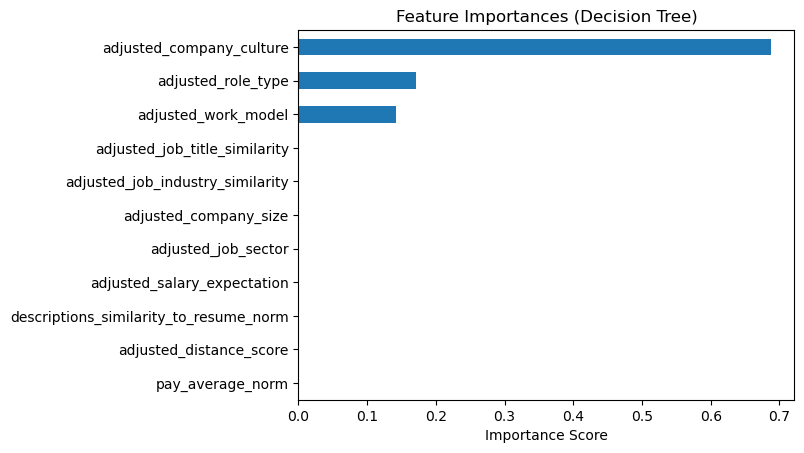

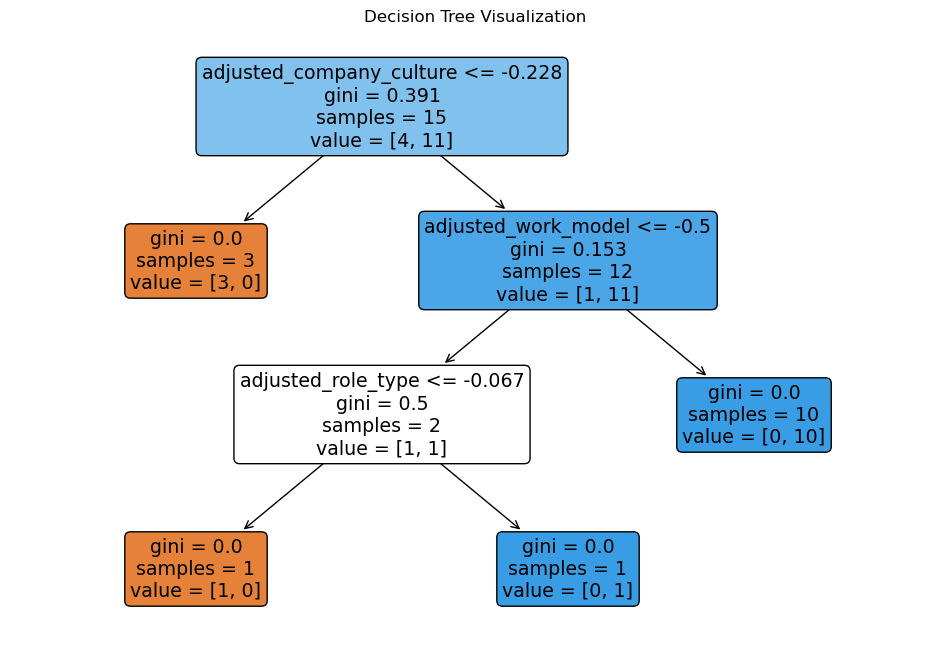

In [68]:

# Visualize Feature Importances from the Decision Tree
feature_importances = pd.Series(model.feature_importances_, index=feature_list_for_XGBoost).sort_values(ascending=False)
print("\nFeature Importances (Decision Tree):")
print(feature_importances)

# Plot the Feature Importances
feature_importances.plot(kind='barh')
plt.xlabel('Importance Score')
plt.title('Feature Importances (Decision Tree)')
plt.gca().invert_yaxis()
plt.show()

# Optional: Visualize the Decision Tree
from sklearn import tree

plt.figure(figsize=(12, 8))
tree.plot_tree(model, feature_names=feature_list_for_XGBoost, filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


In [87]:
import os

# Disable parallelism in Huggingface tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the parameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Initialize the Decision Tree Classifier with balanced class weights
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Use Stratified K-Fold to handle imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best CV score: {best_score:.2f}")


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5; total time

/Users/henrychiu/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


me=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END ccp_alpha=0.0, criterion=entropy,


LOOCV Accuracy Scores: [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0.]
Mean LOOCV Accuracy: 0.67

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.91      0.95        11

    accuracy                           0.93        15
   macro avg       0.90      0.95      0.92        15
weighted avg       0.95      0.93      0.94        15


Confusion Matrix:
[[ 4  0]
 [ 1 10]]


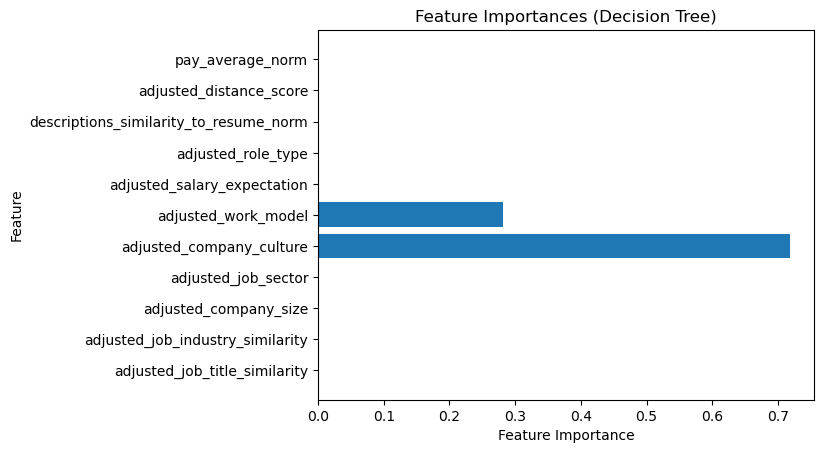

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Best hyperparameters from the grid search
best_params = {
    'criterion': 'entropy',
    'ccp_alpha': 0.0,
    'max_depth': None,
    'max_features': None,
    'min_samples_leaf': 2,
    'min_samples_split': 10
}

# Initialize the Decision Tree Classifier with the best parameters
model = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    ccp_alpha=best_params['ccp_alpha'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42  # Setting a random state for reproducibility
)

# Use Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()

# Perform LOOCV and get the accuracy scores
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"\nLOOCV Accuracy Scores: {scores}")
print(f"Mean LOOCV Accuracy: {scores.mean():.2f}")

# Fit the model on the entire dataset
model.fit(X, y)

# Predict on the entire dataset
y_pred = model.predict(X)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

# Plot feature importance (if available)
if hasattr(model, "feature_importances_"):
    feature_importances = model.feature_importances_
    plt.barh(range(len(feature_importances)), feature_importances, tick_label=feature_list_for_XGBoost)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances (Decision Tree)')
    plt.show()


## Random Forest

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=100,    # Use 10 decision trees in the forest (kept small due to limited data)
    max_depth=5,        # Limit the depth of each tree to prevent overfitting
    max_features='sqrt', # Number of features considered for splitting at each node
    random_state=42,
    bootstrap=True,     # Use bootstrap samples when building trees
)

# Initialize Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()

# Perform LOOCV (Leave-One-Out Cross-Validation)
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"\nLOOCV Accuracy Scores: {scores}")
print(f"Mean LOOCV Accuracy: {scores.mean():.2f}")

# Fit the model on the entire dataset
model.fit(X, y)

# Predict on the entire dataset
y_pred = model.predict(X)

# Evaluate the Model
print("\nClassification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))



LOOCV Accuracy Scores: [1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1.]
Mean LOOCV Accuracy: 0.67

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


Confusion Matrix:
[[ 4  0]
 [ 0 11]]


In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix

# Initialize RandomForestClassifier with predefined hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=4,           # Limit depth of trees
    min_samples_split=2,   # Minimum samples to split a node
    min_samples_leaf=2,    # Minimum samples per leaf node
    random_state=42, 
    max_features='sqrt',
    bootstrap=True # Random state for reproducibility
)

# Use Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()

# Perform LOOCV and get accuracy scores
rf_scores = cross_val_score(rf_model, X, y, cv=loo, scoring='accuracy')
print(f"\nLOOCV Accuracy Scores (Random Forest): {rf_scores}")
print(f"Mean LOOCV Accuracy (Random Forest): {rf_scores.mean():.2f}")

# Fit the model on the entire dataset
rf_model.fit(X, y)

# Predict on the entire dataset
y_pred_rf = rf_model.predict(X)

# Evaluate the model
print("\nClassification Report (Random Forest):")
print(classification_report(y, y_pred_rf))

print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y, y_pred_rf))



LOOCV Accuracy Scores (Random Forest): [1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.]
Mean LOOCV Accuracy (Random Forest): 0.73

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.92      1.00      0.96        11

    accuracy                           0.93        15
   macro avg       0.96      0.88      0.91        15
weighted avg       0.94      0.93      0.93        15


Confusion Matrix (Random Forest):
[[ 3  1]
 [ 0 11]]


In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Initialize RandomForestClassifier with predefined hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=5,           # Limit depth of trees
    min_samples_split=3,   # Minimum samples to split a node
    min_samples_leaf=2,    # Minimum samples per leaf node
    random_state=42        # Random state for reproducibility
)

# Set up K-Fold Cross-Validation with 5 splits
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold CV and get accuracy scores
rf_kfold_scores = cross_val_score(rf_model, X, y, cv=kfold, scoring='accuracy')

# Print the results
print(f"K-Fold CV Accuracy Scores (Random Forest): {rf_kfold_scores}")
print(f"Mean K-Fold CV Accuracy (Random Forest): {rf_kfold_scores.mean():.2f}")

# Train the model on the entire dataset after K-Fold evaluation
rf_model.fit(X, y)

# Predict on the entire dataset
y_pred_rf = rf_model.predict(X)

# Evaluate the model
print("\nClassification Report (Random Forest):")
print(classification_report(y, y_pred_rf))

print("\nConfusion Matrix (Random Forest):")
print


K-Fold CV Accuracy Scores (Random Forest): [1.         0.66666667 1.         0.66666667 0.33333333]
Mean K-Fold CV Accuracy (Random Forest): 0.73

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.92      1.00      0.96        11

    accuracy                           0.93        15
   macro avg       0.96      0.88      0.91        15
weighted avg       0.94      0.93      0.93        15


Confusion Matrix (Random Forest):


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

## XGBoost

In [73]:
# Train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X, y)
# Predict on the entire dataset
y_pred = model.predict(X)

Accuracy: 0.87

LOOCV Accuracy Scores: [0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.]
Mean LOOCV Accuracy: 0.60

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.85      1.00      0.92        11

    accuracy                           0.87        15
   macro avg       0.92      0.75      0.79        15
weighted avg       0.89      0.87      0.85        15


Confusion Matrix:
[[ 2  2]
 [ 0 11]]

Feature Importances (XGBoost Tree-Based):
adjusted_company_culture                  0.382911
adjusted_job_title_similarity             0.156197
pay_average_norm                          0.149135
adjusted_salary_expectation               0.133893
descriptions_similarity_to_resume_norm    0.126497
adjusted_job_industry_similarity          0.051368
adjusted_company_size                     0.000000
adjusted_job_sector                       0.000000
adjusted_work_model                       0.0000

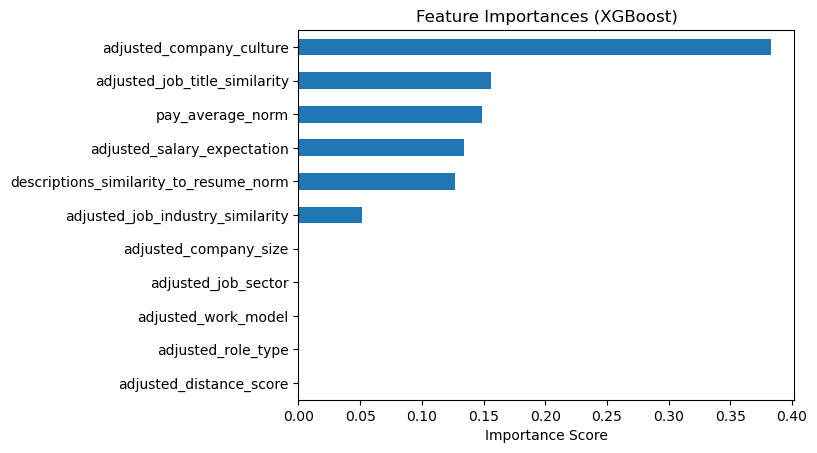

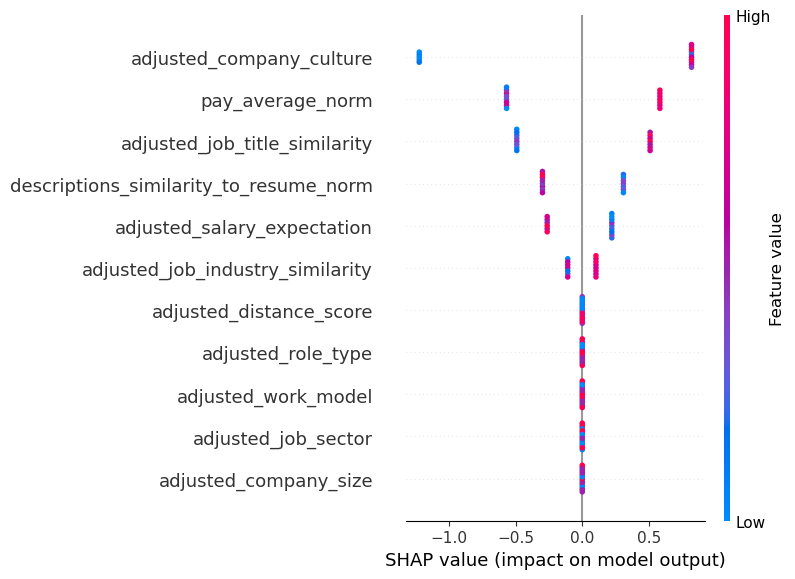

In [74]:
# Evaluate the model
accuracy = model.score(X, y)
print(f'Accuracy: {accuracy:.2f}')

# Initialize LOOCV
loo = LeaveOneOut()

# Perform LOOCV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"\nLOOCV Accuracy Scores: {scores}")
print(f"Mean LOOCV Accuracy: {scores.mean():.2f}")

# Evaluate the Model
print("\nClassification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

# Feature Importance using tree-based method
feature_importances = pd.Series(model.feature_importances_, index=feature_list_job_ranking).sort_values(ascending=False)
print("\nFeature Importances (XGBoost Tree-Based):")
print(feature_importances)

# Plot Feature Importances
feature_importances.plot(kind='barh')
plt.xlabel('Importance Score')
plt.title('Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

# SHAP Values for Model Interpretation (optional)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary Plot
shap.summary_plot(shap_values, X, feature_names=feature_list_job_ranking)


## Linear Regression


LOOCV Accuracy Scores: [1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.]
Mean LOOCV Accuracy: 0.73
Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.85      1.00      0.92        11

    accuracy                           0.87        15
   macro avg       0.92      0.75      0.79        15
weighted avg       0.89      0.87      0.85        15


Confusion Matrix:
[[ 2  2]
 [ 0 11]]

Feature Importances (Logistic Regression Coefficients):
adjusted_company_culture                  0.668653
adjusted_work_model                       0.586557
adjusted_job_sector                       0.562413
pay_average_norm                          0.472585
adjusted_job_title_similarity             0.236917
descriptions_similarity_to_resume_norm    0.144908
adjusted_company_size                     0.120605
adjusted_job_industry_similarity          0.076272
adjusted_role_type                

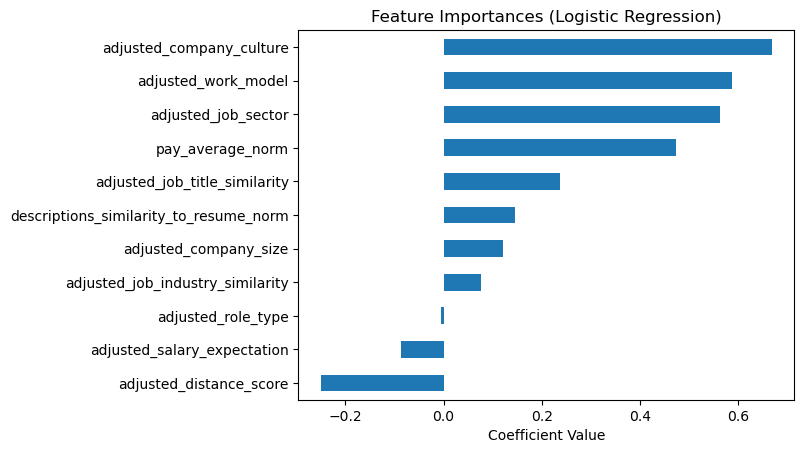

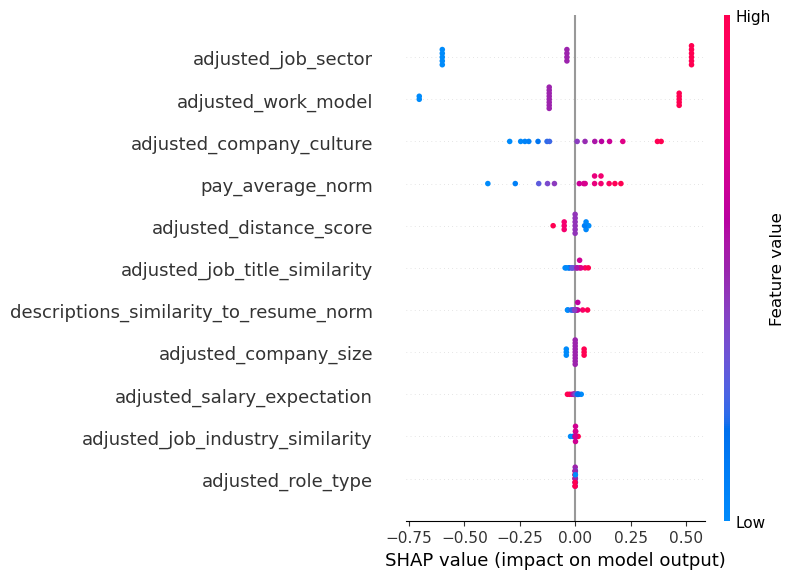

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import shap



# Initialize the model with L2 regularization
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    random_state=42
)


# Initialize LOOCV
loo = LeaveOneOut()

# Perform LOOCV
scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy')
print(f"\nLOOCV Accuracy Scores: {scores}")
print(f"Mean LOOCV Accuracy: {scores.mean():.2f}")

# Fit the model on the entire dataset
model.fit(X, y)


accuracy = model.score(X, y)
print(f'Accuracy: {accuracy:.2f}')
# Predict on the entire dataset
y_pred = model.predict(X)

# Evaluate the Model
print("\nClassification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

# Feature Importance using coefficients
feature_importances = pd.Series(model.coef_[0], index=feature_list_for_XGBoost).sort_values(ascending=False)
print("\nFeature Importances (Logistic Regression Coefficients):")
print(feature_importances)

# Plot Feature Importances
feature_importances.plot(kind='barh')
plt.xlabel('Coefficient Value')
plt.title('Feature Importances (Logistic Regression)')
plt.gca().invert_yaxis()
plt.show()

# SHAP Values for Model Interpretation (optional)
# Note: With such a small dataset, SHAP may not provide meaningful insights
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Summary Plot
shap.summary_plot(shap_values, X, feature_names=feature_list_for_XGBoost)


In [133]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

# Define hyperparameters for tuning
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'penalty': ['l2', 'l1'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 and L2
}

# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Set up KFold Cross-Validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=1)
grid_search.fit(X, y)

# Best parameters from Grid Search
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

# Fit the best model on the entire dataset
best_model = grid_search.best_estimator_
best_model.fit(X, y)

# Evaluate the tuned model
y_pred = best_model.predict(X)
print("\nClassification Report (Tuned Logistic Regression):")
print(classification_report(y, y_pred))

print("\nConfusion Matrix (Tuned Logistic Regression):")
print(confusion_matrix(y, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.73

Classification Report (Tuned Logistic Regression):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.73      1.00      0.85        11

    accuracy                           0.73        15
   macro avg       0.37      0.50      0.42        15
weighted avg       0.54      0.73      0.62        15


Confusion Matrix (Tuned Logistic Regression):
[[ 0  4]
 [ 0 11]]


/Users/henrychiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/henrychiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/henrychiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/henrychiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/henrychiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/henrychiu/anaconda3/lib/python3.11/sit

## Calculate ranking of job base on user's preference from AB comparisons


In [69]:
new_jobs = df_new_for_XGboost

# Generate all possible pairs of new jobs
new_job_ids = new_jobs.index.values
new_job_pairs = [(new_job_ids[i], new_job_ids[j]) for i in range(len(new_job_ids)) for j in range(i + 1, len(new_job_ids))]



# Create a DataFrame to hold scores
job_scores = pd.Series(0, index=new_job_ids)

# Calculate feature differences and predict preferences
for job_A, job_B in new_job_pairs:

    
    # Create the feature difference using the function
    row = {'job_A_id': job_A, 'job_B_id': job_B}
    feature_diff_array = create_feature_diff(row, new_jobs.drop(columns=['PostId'])).reshape(1, -1)
    
    # Predict preference
    prob_A_preferred = model.predict_proba(feature_diff_array)[0, 1]
    
    # Update scores
    job_scores[job_A] += prob_A_preferred
    job_scores[job_B] += (1 - prob_A_preferred)



In [70]:
# Sort the job scores in ascending order
ranked_jobs_descending = job_scores.sort_values(ascending=False)

# Retrieve the corresponding rows from the new_jobs DataFrame
ranked_jobs_df_descending = new_jobs.loc[ranked_jobs_descending.index]

# Add the job scores as a new column
ranked_jobs_df_descending['job_score'] = ranked_jobs_descending.values

ranked_jobs_path = os.path.join(script_dir, 'output', 'ranked_jobs.json') 
ranked_jobs_json = ranked_jobs_df_descending[['PostId', 'job_score']].to_json(ranked_jobs_path, orient='records', indent=4)
#print(ranked_jobs_json)


Ranked Jobs Descending Order with Scores:
       PostId  job_score
7   73002207         99
0   57192643         97
24  75219974         94
25  75219977         93
26  75219980         92
..       ...        ...
83  76477930          9
99  76563900          7
47  76017801          5
84  76480181          4
64  76249302          0

[100 rows x 2 columns]


In [71]:
# Set pandas option to display all rows
pd.set_option('display.max_rows', None)

# Display the ranked jobs in ascending order
print("Ranked Jobs Descending Order with Scores:\n", ranked_jobs_df_descending[['PostId','job_score']])

# Reset pandas option to default after printing
pd.reset_option('display.max_rows')

Ranked Jobs Descending Order with Scores:
       PostId  job_score
7   73002207         99
0   57192643         97
24  75219974         94
25  75219977         93
26  75219980         92
19  74928503         92
27  75220789         91
30  75422486         89
92  76530004         89
17  74777089         89
10  73382292         87
2   71358671         86
45  75998593         86
85  76494766         85
88  76499389         81
16  74615270         80
56  76062765         80
96  76550767         80
39  75761061         79
23  75080427         75
76  76432656         75
11  73624091         74
28  75265546         72
34  75681159         72
74  76414730         72
69  76347228         71
1   69699264         71
13  74517855         71
12  73866910         70
40  75824572         70
95  76550754         69
37  75750371         67
67  76282615         65
9   73238403         65
38  75760226         63
3   71486532         63
15  74597923         61
94  76538182         60
32  75530171         

In [ ]:
#total_score = job_scores.sum()
#print("Total Job Score:", total_score)

Total Job Score: 4950.0
